In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from scipy import stats
from scipy.stats import norm,skew
import warnings
from sklearn.preprocessing import RobustScaler
warnings.filterwarnings("ignore")
%matplotlib inline
# MinMaxScaler用於數據的歸一化
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score

# 讀取數據

data_path = r'C:\Users\rex\Desktop\水位預測\1\水位_整理.csv'
data = pd.read_csv(data_path)

print (data)
data.head(5)



      Station No        Date   Time  1510H084 Water Level  \
0       1510H084    2015/1/1  00:00                146.20   
1       1510H084    2015/1/1  01:00                146.18   
2       1510H084    2015/1/1  02:00                146.22   
3       1510H084    2015/1/1  03:00                146.24   
4       1510H084    2015/1/1  04:00                146.25   
...          ...         ...    ...                   ...   
70123   1510H084  2022/12/31  19:00                143.63   
70124   1510H084  2022/12/31  20:00                143.63   
70125   1510H084  2022/12/31  21:00                143.63   
70126   1510H084  2022/12/31  22:00                143.64   
70127   1510H084  2022/12/31  23:00                143.63   

       1510H076 Water Level  1510H071 Water Level  1510H057 Water Level  
0                      4.41                 20.45                 89.29  
1                      4.40                 20.51                 89.35  
2                      4.40                 2

,Station No,Date,Time,1510H084 Water Level,1510H076 Water Level,1510H071 Water Level,1510H057 Water Level
0,1510H084,2015/1/1,00:00,146.20,4.41,20.45,89.29
1,1510H084,2015/1/1,01:00,146.18,4.40,20.51,89.35
2,1510H084,2015/1/1,02:00,146.22,4.40,20.50,89.33
3,1510H084,2015/1/1,03:00,146.24,4.40,20.50,89.33
4,1510H084,2015/1/1,04:00,146.25,4.41,20.50,89.36


In [2]:
import sys
print(sys.executable)

c:\Users\rex\Anaconda3\envs\tf-GPU\python.exe


In [3]:
# 合併日期和時間為單一時間戳，並設為索引
data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data = data.set_index('Timestamp')

# 刪除不必要的列
data = data.drop(['Station No', 'Date', 'Time'], axis=1)


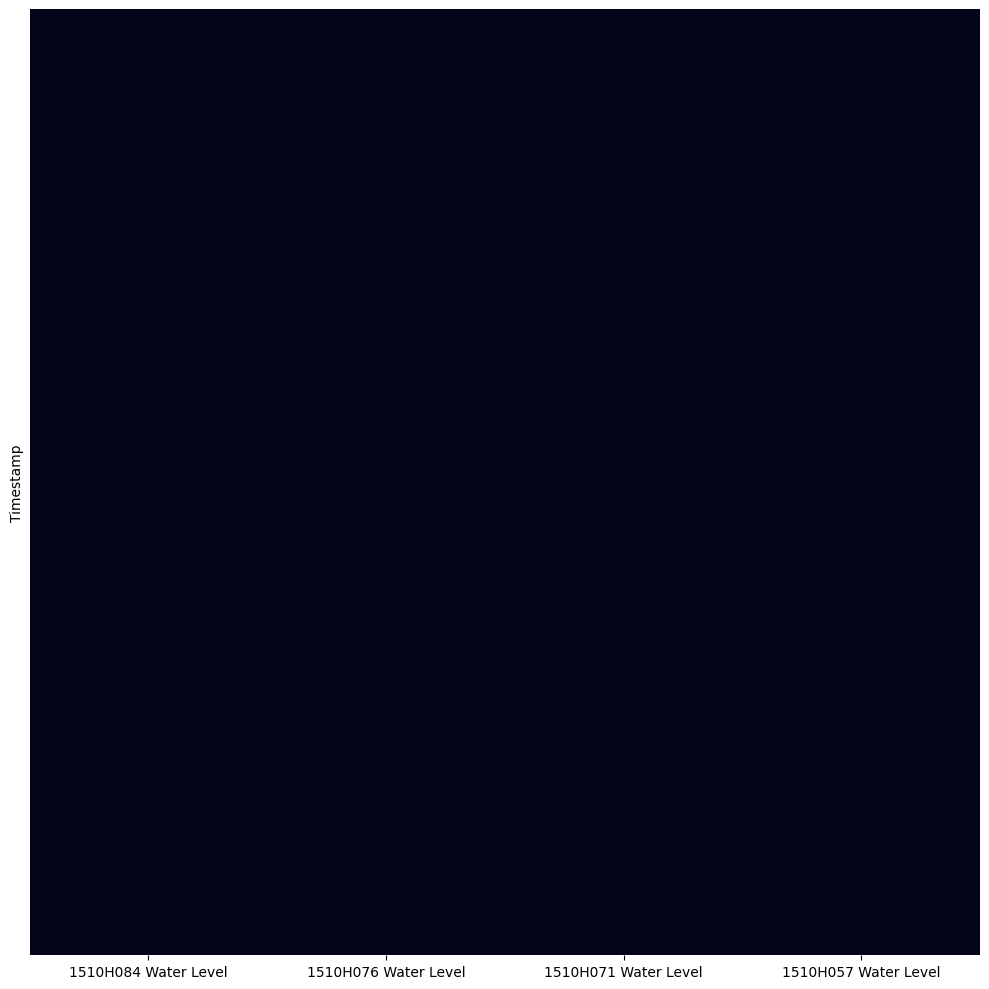

In [5]:
#isnull()看數據缺失值
plt.figure(figsize=(10,10))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False)
plt.tight_layout()
plt.show()

In [7]:
#看數據維度
print(data.shape)
#看數據訊息
data.info()

(70128, 4)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70128 entries, 2015-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1510H084 Water Level  70128 non-null  float64
 1   1510H076 Water Level  70128 non-null  float64
 2   1510H071 Water Level  70128 non-null  float64
 3   1510H057 Water Level  70128 non-null  float64
dtypes: float64(4)
memory usage: 2.7 MB


In [ ]:
#無氣提相關性分析

targets = ["1510H084 Water Level", "1510H076 Water Level", "1510H071 Water Level", "1510H057 Water Level"]
k = 10
corrmat = data.corr()
cols = corrmat.nlargest(k, targets)[targets].index
cm = np.corrcoef(data[cols].values.T)

fig, ax = plt.subplots(figsize=(8, 8))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.3f', annot_kws={'size':10},
            yticklabels=cols.values, xticklabels=cols.values, cmap='RdYlBu_r', vmin=0.6, vmax=1.0)
plt.title(f"Top {k} Correlations with Targets")
plt.show()


In [8]:
# 歸一化數據
scalers = {}
for i in data.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    s_s = scaler.fit_transform(data[i].values.reshape(-1,1))
    s_s = np.reshape(s_s, len(s_s))
    scalers['scaler_'+ i] = scaler
    data[i] = s_s

In [9]:
# 切分訓練集與測試集
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# 定義一個函數來創建輸入序列和目標序列
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# 創建輸入序列和目標序列
time_steps = 48
X_train, y_train = create_dataset(train, train, time_steps)
X_test, y_test = create_dataset(test, test, time_steps)

# 定義LSTM模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(4))

# 編譯模型
model.compile(optimizer='adam', loss='mse')

# 訓練模型
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

# 進行預測
y_pred = model.predict(X_test)

# 將預測值和實際值的縮放反轉回來
for i in range(y_pred.shape[1]):
    y_pred[:, i] = scalers['scaler_' + data.columns[i]].inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
    y_test[:, i] = scalers['scaler_' + data.columns[i]].inverse_transform(y_test[:, i].reshape(-1, 1)).flatten()

# 計算R^2 score
r2 = r2_score(y_test, y_pred)
print('R^2 score:', r2)

Epoch 1/10
1577/1577 [==============================] - 124s 78ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 2/10
1577/1577 [==============================] - ETA: 0s - loss: 0.0011